### Konfiguracja nowego klienta Hazelcast

In [33]:
import hazelcast

client = hazelcast.HazelcastClient(
            cluster_name = "dev",
            cluster_members=["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"],
        )


DEBUG:hazelcast.reactor:Starting Reactor Thread
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is STARTING
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is STARTED
INFO:hazelcast.connection:Trying to connect to Address(host=127.0.0.1, port=5702)
DEBUG:hazelcast.reactor:Connected to Address(host=127.0.0.1, port=5702)
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is CONNECTED
INFO:hazelcast.connection:Authenticated with server Address(host=172.21.0.2, port=5701):b3bb0ffd-1b38-4ecd-b459-4fbb718f2b19, server version: 5.5.0, local address: Address(host=127.0.0.1, port=14384)
DEBUG:hazelcast.cluster:Resetting the member list version
DEBUG:hazelcast.cluster:Handling new snapshot with membership version: 3, member string: 

Members [3] {
	Member [172.21.0.2]:5701 - b3bb0ffd-1b38-4ecd-b459-4fbb718f2b19
	Member [172.21.0.3]:5701 - e5010b3a-f453-4b65-9bec-78b23dc450b3
	Member [172.21.0.4]:5701 - 5195a3bf-e70f-45c2-8a18-88c675b5e7f3
}

INFO:hazelcast.cluster:

Members [3] {
	Member [172.21.0.2]:

INFO:hazelcast.connection:Connection(id=3, live=False, remote_address=None) closed. Reason: Connection timed out
DEBUG:hazelcast.connection:Destroying Connection(id=3, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
INFO:hazelcast.connection:Connection(id=4, live=False, remote_address=None) closed. Reason: Connection timed out
DEBUG:hazelcast.connection:Destroying Connection(id=4, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=7, retryable=True), error: TargetDisconnectedError
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=8, retryable=True), error: TargetDisconnectedError
INFO:hazelcast.connection:Connection(id=5, live=False, remote_address=None) closed. Reason: Connection timed out
DEBUG

Debug - sprawdzenie typu klucza: 

In [2]:
imap = client.get_map("trades").blocking()
entry_set = imap.entry_set()
first_key, _ = next(iter(entry_set))
print(f"Key type: {type(first_key)}") 
print(f"Value type: {type(_)}") 

Key type: <class 'str'>
Value type: <class 'hazelcast.core.HazelcastJsonValue'>


### Mapping SQL - prosty przykład

In [49]:
cities = client.get_map("cities").blocking()

client.sql.execute(
    """
CREATE OR REPLACE MAPPING cities (
__key INT,
countries VARCHAR,
cities VARCHAR)
TYPE IMap
OPTIONS('keyFormat'='int', 'valueFormat'='json-flat')

    """
).result()

client.sql.execute(
    """
INSERT INTO cities VALUES
(1, 'United Kingdom','London'),
(2, 'United Kingdom','Manchester'),
(3, 'United States', 'New York'),
(4, 'United States', 'Los Angeles'),
(5, 'Turkey', 'Ankara'),
(6, 'Turkey', 'Istanbul'),
(7, 'Brazil', 'Sao Paulo'),
(8, 'Brazil', 'Rio de Janeiro')
    """
).result()

result = client.sql.execute("SELECT * FROM cities").result()


In [50]:
for row in result:
    print(row)

[__key INTEGER=2, countries VARCHAR=United Kingdom, cities VARCHAR=Manchester]
[__key INTEGER=6, countries VARCHAR=Turkey, cities VARCHAR=Istanbul]
[__key INTEGER=1, countries VARCHAR=United Kingdom, cities VARCHAR=London]
[__key INTEGER=7, countries VARCHAR=Brazil, cities VARCHAR=Sao Paulo]
[__key INTEGER=8, countries VARCHAR=Brazil, cities VARCHAR=Rio de Janeiro]
[__key INTEGER=3, countries VARCHAR=United States, cities VARCHAR=New York]
[__key INTEGER=5, countries VARCHAR=Turkey, cities VARCHAR=Ankara]
[__key INTEGER=4, countries VARCHAR=United States, cities VARCHAR=Los Angeles]


In [60]:
# Zamknięcie klienta Hazelcast
client.shutdown()

INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is SHUTTING_DOWN
DEBUG:hazelcast.connection:Connection(id=0, live=False, remote_address=Address(host=172.20.0.4, port=5701)) closed. Reason: Hazelcast client is shutting down
INFO:hazelcast.connection:Removed connection to Address(host=172.20.0.4, port=5701):19566e8f-c7d4-4fa9-80fd-3b2fd7a9b0ca, connection: Connection(id=0, live=False, remote_address=Address(host=172.20.0.4, port=5701))
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is DISCONNECTED
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=274, retryable=True), error: Client is not active
DEBUG:hazelcast.connection:Connection(id=171, live=False, remote_address=None) closed. Reason: Failed to authenticate connection
DEBUG:hazelcast.connection:Destroying Connection(id=171, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
DEBUG:hazelcast.invocation:Got exception f

### Zapytania SQL - Trades

Mapa przechowywująca wszystkie transakcje, przechwycane z websocketa i umieszczane w czasie rzeczywistym, dla kursów:
* BTC-USD
* ETH-USD

A więc analizę danych możemy wykonać po stronie tego klienta.

In [34]:
#trades = client.get_map("coinbase_trades").blocking()

client.sql.execute("""
        CREATE OR REPLACE MAPPING trades (
            trade_id VARCHAR,
            product_id VARCHAR,
            price DOUBLE,
            volume DOUBLE,
            time_iso VARCHAR,
            time_unix BIGINT,
            side VARCHAR
        )
        TYPE IMap
        OPTIONS (
            'keyFormat' = 'varchar',
            'valueFormat' = 'json-flat'
        )
        """)


In [4]:
result_trades = client.sql.execute(
    """  
    SELECT  * 
    FROM trades 
    where cast(price  as decimal) > 99416
    LIMIT 10
    """).result()

for row in result_trades:
    print(row)

[trade_id VARCHAR=934524662450225154, product_id VARCHAR=BTC-USD, price DOUBLE=104086.12, volume DOUBLE=4.015e-05, time_iso VARCHAR=2025-01-22T19:07:24.502034Z, time_unix BIGINT=1737572844502, side VARCHAR=sell]
[trade_id VARCHAR=934525212803596290, product_id VARCHAR=BTC-USD, price DOUBLE=104199.71, volume DOUBLE=0.0001632, time_iso VARCHAR=2025-01-22T19:09:34.093947Z, time_unix BIGINT=1737572974093, side VARCHAR=sell]
[trade_id VARCHAR=934524969216311298, product_id VARCHAR=BTC-USD, price DOUBLE=104126.43, volume DOUBLE=0.03621833, time_iso VARCHAR=2025-01-22T19:08:37.154868Z, time_unix BIGINT=1737572917154, side VARCHAR=buy]
[trade_id VARCHAR=934525103858319361, product_id VARCHAR=BTC-USD, price DOUBLE=104200.02, volume DOUBLE=1.7e-05, time_iso VARCHAR=2025-01-22T19:09:10.787395Z, time_unix BIGINT=1737572950787, side VARCHAR=sell]
[trade_id VARCHAR=934524905772613635, product_id VARCHAR=BTC-USD, price DOUBLE=104053.65, volume DOUBLE=0.01, time_iso VARCHAR=2025-01-22T19:08:21.393743Z

### Średnia cena w interwałach czasowych (10 min)

In [35]:
query =   """
    SELECT 
    CAST(FLOOR(time_unix / 600000) * 600000 AS BIGINT) AS time_bucket,
    AVG(price) AS avg_price
    FROM trades
    WHERE product_id = 'BTC-USD'
    GROUP BY time_bucket
    ORDER BY time_bucket;

    """

[datetime.datetime(2025, 1, 22, 19, 0), datetime.datetime(2025, 1, 22, 19, 10), datetime.datetime(2025, 1, 22, 19, 20)]


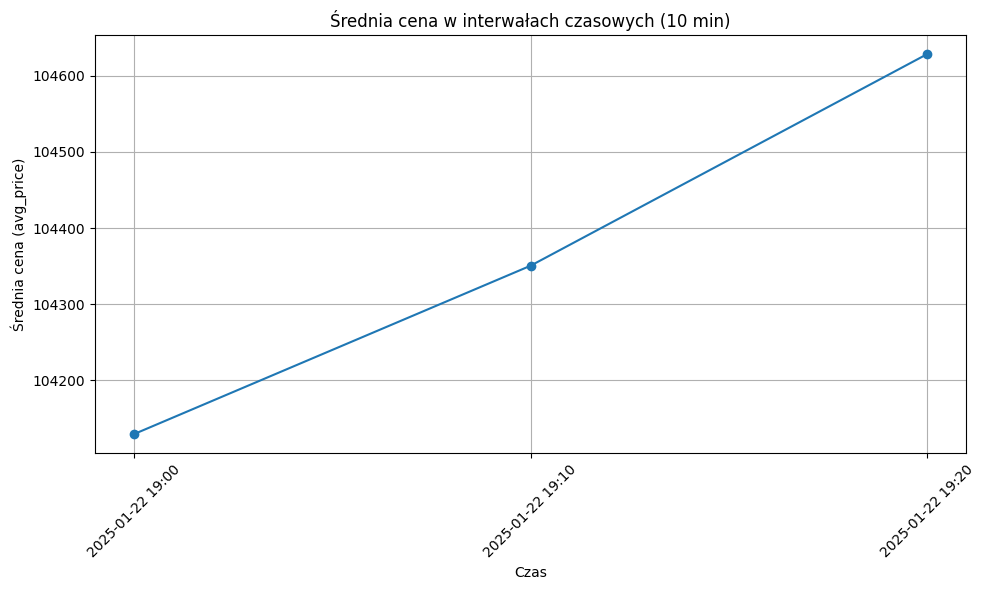

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

result_trades = client.sql.execute(query).result()

def convert_time_bucket_to_datetime(time_bucket):
    return datetime.utcfromtimestamp(time_bucket / 1000)

time_buckets = []
avg_prices = []

for row in result_trades:
    time_buckets.append(convert_time_bucket_to_datetime(row["time_bucket"]))
    avg_prices.append(row["avg_price"])

print(time_buckets)
# Tworzenie DataFrame
df = pd.DataFrame({"time_bucket": time_buckets, "avg_price": avg_prices})

plt.figure(figsize=(10, 6))
plt.plot(df["time_bucket"], df["avg_price"], marker='o')
plt.title("Średnia cena w interwałach czasowych (10 min)")
plt.xlabel("Czas")
plt.ylabel("Średnia cena (avg_price)")

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(time_buckets, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

###  Top 10 transakcji o najwyższej cenie

In [37]:
query= """
    SELECT 
        time_unix AS transaction_time,
        price AS price,
        volume AS volume
    FROM trades
    WHERE product_id = 'BTC-USD'
    ORDER BY price DESC
    LIMIT 10;

    """
result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "transaction_time": row["transaction_time"],  
        "price": row["price"],
        "volume": row["volume"]
    }
    trade["transaction_time"] = datetime.utcfromtimestamp(trade["transaction_time"] / 1000).strftime('%Y-%m-%d %H:%M')
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

   transaction_time      price    volume
0  2025-01-22 19:23  104729.33  0.582328
1  2025-01-22 19:23  104729.27  0.028544
2  2025-01-22 19:23  104728.26  0.000024
3  2025-01-22 19:23  104728.00  0.446000
4  2025-01-22 19:23  104727.77  0.024996
5  2025-01-22 19:23  104727.30  0.000036
6  2025-01-22 19:23  104725.55  0.619371
7  2025-01-22 19:23  104725.54  1.470981
8  2025-01-22 19:23  104725.37  0.054000
9  2025-01-22 19:23  104725.27  0.477440


### Średnia cena transakcji w stosunku do godziny dnia

   hour_of_day     avg_price
0           19  104372.02844


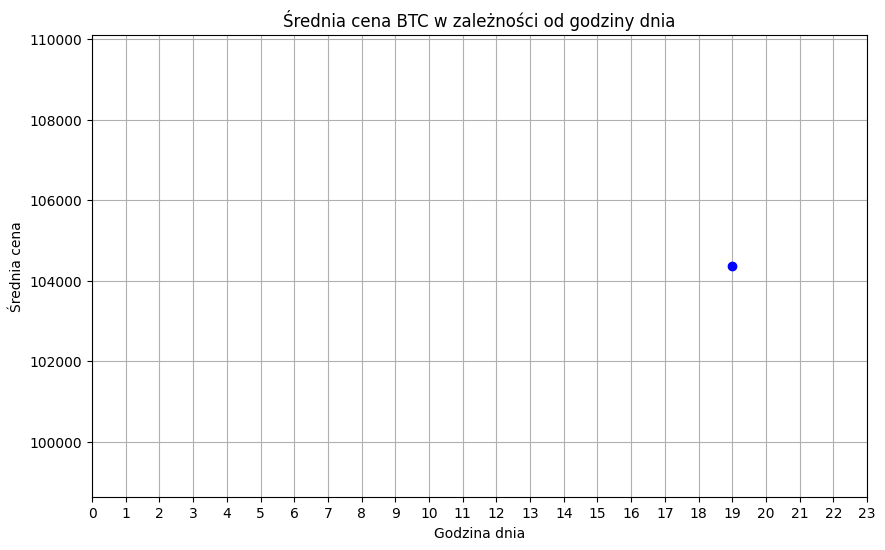

In [38]:
import pandas as pd
from datetime import datetime

query = """

SELECT 
    CAST((time_unix / 3600000) % 24 AS INT) AS hour_of_day,
    AVG(price) AS avg_price
FROM trades
WHERE product_id = 'BTC-USD'
GROUP BY hour_of_day
ORDER BY hour_of_day;

"""

result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "hour_of_day": row["hour_of_day"],
        "avg_price": row["avg_price"]
    }
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

plt.figure(figsize=(10, 6))
plt.plot(df['hour_of_day'], df['avg_price'], marker='o', linestyle='-', color='b')
plt.title('Średnia cena BTC w zależności od godziny dnia')
plt.xlabel('Godzina dnia')
plt.ylabel('Średnia cena')
plt.grid(True)
plt.xticks(range(24))  
plt.show()

### Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny

1737569548251


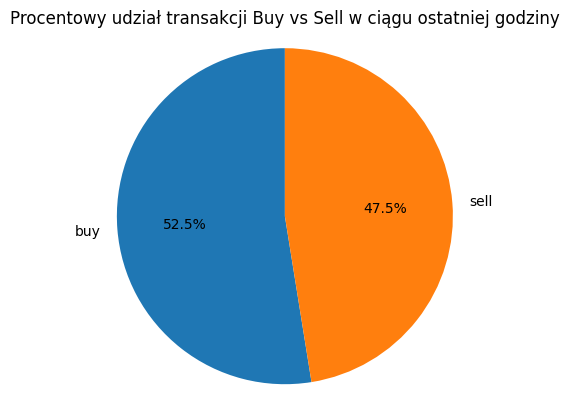

In [9]:
from collections import Counter

from datetime import datetime

current_timestamp = int(datetime.utcnow().timestamp() * 1000)
print(current_timestamp)

query = f"""
SELECT 
    side AS transaction_type,
    time_unix AS transaction_time
FROM trades
WHERE product_id = 'BTC-USD'
    AND time_unix > {current_timestamp - 3600000} 
ORDER BY transaction_time;

"""

result_trades = client.sql.execute(query).result()

transaction_types = [trade["transaction_type"] for trade in result_trades]

counter = Counter(transaction_types)

labels = counter.keys()
sizes = counter.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal') 

plt.title("Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny")
plt.show()

### SQL - Aggregated Trades

Mapa przechowywująca zagregowane dane na temat dwóch kursów: 
* BTC-USD
* ETH-USD

In [10]:
client.sql.execute("""
CREATE OR REPLACE MAPPING aggregated_trades (
    product_id VARCHAR,
    average_price DOUBLE,
    total_volume DOUBLE,
    last_updated BIGINT
)
TYPE IMap
OPTIONS (
    'keyFormat' = 'varchar',
    'valueFormat' = 'json-flat'
)
""")

In [11]:

query = '''
SELECT 
    product_id,
    average_price,
    total_volume,
    last_updated
FROM aggregated_trades
ORDER BY last_updated DESC;
'''

result_trades = client.sql.execute(query).result()
result_trades_dict = []
for row in result_trades:
    trade = {
        "product_id": row["product_id"],  
        "average_price": row["average_price"],
        "average_price": row["average_price"]
    }
    trade["last_updated"] =        datetime.fromtimestamp(row["last_updated"] / 1000).strftime('%Y-%m-%d %H:%M:%S')  # Konwersja timestamp na czytelny format

    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

  product_id  average_price         last_updated
0    ETH-USD    3255.277054  2025-01-22 20:12:35
1    BTC-USD  104166.715268  2025-01-22 20:12:35


### Cachowanie

In [13]:
from hazelcast.config import Config, NearCacheConfig

In [14]:
config = Config()
config.cluster_name = "dev"
config.cluster_members = ["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"]

near_cache_config = NearCacheConfig()
near_cache_config.time_to_live = 120 # czas życia wpisów w Near Cache
near_cache_config.max_idle = 60 # maksymalny czas bezczynności

config.near_caches = {
    "cache-map": near_cache_config,
}

client = hazelcast.HazelcastClient(config)

In [15]:
import time

In [16]:
cache_map = client.get_map("cache-map").blocking()

cache_map.put("key", "value")

start_time = time.perf_counter()
print(cache_map.get("key")) # odczyt z serwera
elapsed_time_1 = (time.perf_counter() - start_time) * 1000

start_time = time.perf_counter()
print(cache_map.get("key")) # odczyt z Near Cache
elapsed_time_2 = (time.perf_counter() - start_time) * 1000

print(f"Czas odczytu z serwera: {elapsed_time_1:.2f} ms")
print(f"Czas odczytu z cache: {elapsed_time_2:.2f} ms")

value
value
Czas odczytu z serwera: 18.95 ms
Czas odczytu z cache: 0.19 ms


In [ ]:
client.shutdown()

### Przetwarzanie po stronie klienta

In [17]:
from hazelcast.aggregator import count, number_avg, max_by
from hazelcast.predicate import less_or_equal

In [18]:
people = client.get_map("people").blocking()

people.put_all(
    {
        "Adam": 78,
        "Eliza": 67,
        "Henryk": 13,
        "Patrycja": 15,
        "Alexii": 4,
        "Wojciech": 33,
        "Genya": 29,
        "Oleksandr": 49,
        "Pola": 51,
    }
)

people_count = people.aggregate(count())
print("Aktualnie jest {} osób".format(people_count))

children_count = people.aggregate(count(), less_or_equal("this", 18))
print("Z tego {} jest jeszcze dziećmi".format(children_count))

average_age = people.aggregate(number_avg())
print("Średnia wieku wynosi {:.2f}".format(average_age))

eldest_person = people.aggregate(max_by("this"))
print("Najstarsza osoba to {}, ma {} lat".format(eldest_person.key, eldest_person.value))

Aktualnie jest 9 osób
Z tego 3 jest jeszcze dziećmi
Średnia wieku wynosi 37.67
Najstarsza osoba to Adam, ma 78 lat


In [78]:
client.shutdown()

INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is SHUTTING_DOWN
DEBUG:hazelcast.connection:Connection(id=0, live=False, remote_address=Address(host=172.20.0.4, port=5701)) closed. Reason: Hazelcast client is shutting down
INFO:hazelcast.connection:Removed connection to Address(host=172.20.0.4, port=5701):19566e8f-c7d4-4fa9-80fd-3b2fd7a9b0ca, connection: Connection(id=0, live=False, remote_address=Address(host=172.20.0.4, port=5701))
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is DISCONNECTED
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=2938, retryable=True), error: Client is not active
DEBUG:hazelcast.connection:Connection(id=1837, live=False, remote_address=None) closed. Reason: Failed to authenticate connection
DEBUG:hazelcast.connection:Destroying Connection(id=1837, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
DEBUG:hazelcast.invocation:Got exceptio

### Map Listener

In [23]:
client =  hazelcast.HazelcastClient()

my_map = client.get_map("listener-map-1").blocking()

In [24]:
def entry_added(event):
    print("Dodano pozycję o kluczu {} i wartości {}".format(event.key, event.value))

def entry_removed(event):
    print("Usunięto pozycję o kluczu {}".format(event.key))

def entry_updated(event):
    print("Zmieniono wartość pozycji o kluczu {} z {} na {}".format(event.key, event.old_value, event.value))



my_map.add_entry_listener(True, added_func=entry_added, removed_func=entry_removed, updated_func=entry_updated)

my_map.put("key", "value")
my_map.put("key", "new value")
my_map.remove("key")

time.sleep(5)


Dodano pozycję o kluczu key i wartości value
Zmieniono wartość pozycji o kluczu key z value na new value
Usunięto pozycję o kluczu key


In [83]:
client.shutdown()

INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is SHUTTING_DOWN
DEBUG:hazelcast.connection:Connection(id=0, live=False, remote_address=Address(host=172.20.0.2, port=5701)) closed. Reason: Hazelcast client is shutting down
INFO:hazelcast.connection:Removed connection to Address(host=172.20.0.2, port=5701):4d2a1c01-bd42-4b54-a4d4-6bb3819797df, connection: Connection(id=0, live=False, remote_address=Address(host=172.20.0.2, port=5701))
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is DISCONNECTED
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=130, retryable=True), error: Client is not active
DEBUG:hazelcast.connection:Connection(id=81, live=False, remote_address=None) closed. Reason: Failed to authenticate connection
DEBUG:hazelcast.connection:Destroying Connection(id=81, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
DEBUG:hazelcast.invocation:Got exception for

### Subskrypcja do Topic

In [30]:
import hazelcast
import time
import logging

logging.basicConfig(level=logging.DEBUG) 
logger = logging.getLogger(__name__)


def on_message(event):
    print("Got message:", event.message)
    print("Publish time:", event.publish_time)

client = hazelcast.HazelcastClient(
    cluster_name="dev",
    cluster_members=["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"],
    connection_timeout=30000,  
    reconnect_mode='ON',  # Włączona ponowna próba połączenia - bez tego nie działa odbieranie topica 
)

# Inicjalizujemy klienta

topic = client.get_topic("topic").blocking()
topic.add_listener(on_message)

time.sleep(10)



DEBUG:hazelcast.reactor:Starting Reactor Thread
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is STARTING
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is STARTED
INFO:hazelcast.connection:Trying to connect to Address(host=127.0.0.1, port=5701)
DEBUG:hazelcast.reactor:Connected to Address(host=127.0.0.1, port=5701)
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is CONNECTED
INFO:hazelcast.connection:Authenticated with server Address(host=172.21.0.3, port=5701):e5010b3a-f453-4b65-9bec-78b23dc450b3, server version: 5.5.0, local address: Address(host=127.0.0.1, port=13796)
DEBUG:hazelcast.cluster:Resetting the member list version
DEBUG:hazelcast.cluster:Handling new snapshot with membership version: 3, member string: 

Members [3] {
	Member [172.21.0.2]:5701 - b3bb0ffd-1b38-4ecd-b459-4fbb718f2b19
	Member [172.21.0.3]:5701 - e5010b3a-f453-4b65-9bec-78b23dc450b3
	Member [172.21.0.4]:5701 - 5195a3bf-e70f-45c2-8a18-88c675b5e7f3
}

INFO:hazelcast.cluster:

Members [3] {
	Member [172.21.0.2]:

Got message: {"trade_id": "934528213710077955", "product_id": "ETH-USD", "price": 3272.81, "volume": 4.98286796, "time_iso": "2025-01-22T19:21:28.956826Z", "time_unix": 1737573688956, "side": "sell"}
Publish time: 1737573689.026
Got message: {"trade_id": "934528213710143491", "product_id": "ETH-USD", "price": 3272.81, "volume": 3.24850153, "time_iso": "2025-01-22T19:21:28.956926Z", "time_unix": 1737573688956, "side": "sell"}
Publish time: 1737573689.03
Got message: {"trade_id": "934528213710602243", "product_id": "BTC-USD", "price": 104587.05, "volume": 0.177914, "time_iso": "2025-01-22T19:21:28.964323Z", "time_unix": 1737573688964, "side": "sell"}
Publish time: 1737573689.044


INFO:hazelcast.connection:Connection(id=3, live=False, remote_address=None) closed. Reason: Connection closed by server
DEBUG:hazelcast.connection:Destroying Connection(id=3, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
INFO:hazelcast.connection:Connection(id=4, live=False, remote_address=None) closed. Reason: Connection closed by server
DEBUG:hazelcast.connection:Destroying Connection(id=4, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=16, retryable=True), error: TargetDisconnectedError
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=17, retryable=True), error: TargetDisconnectedError


Got message: {"trade_id": "934528224410402817", "product_id": "BTC-USD", "price": 104589.3, "volume": 0.15994525, "time_iso": "2025-01-22T19:21:31.310664Z", "time_unix": 1737573691310, "side": "buy"}
Publish time: 1737573691.432
Got message: {"trade_id": "934528224410468353", "product_id": "BTC-USD", "price": 104589.31, "volume": 0.3014339, "time_iso": "2025-01-22T19:21:31.310664Z", "time_unix": 1737573691310, "side": "buy"}
Publish time: 1737573691.433
Got message: {"trade_id": "934528224410796033", "product_id": "BTC-USD", "price": 104590.67, "volume": 0.70987681, "time_iso": "2025-01-22T19:21:31.317909Z", "time_unix": 1737573691317, "side": "sell"}
Publish time: 1737573691.446


DEBUG:hazelcast.partition:Handling new partition table with version: 16
DEBUG:hazelcast.partition:Partition view will not be applied since response state version is older. Sending connection: Connection(id=0, live=True, remote_address=Address(host=172.21.0.3, port=5701)), version: 16, current table: PartitionTable(connection=Connection(id=0, live=True, remote_address=Address(host=172.21.0.3, port=5701)), version=16)
DEBUG:hazelcast.cluster:Handling new snapshot with membership version: 3, member string: 

Members [3] {
	Member [172.21.0.2]:5701 - b3bb0ffd-1b38-4ecd-b459-4fbb718f2b19
	Member [172.21.0.3]:5701 - e5010b3a-f453-4b65-9bec-78b23dc450b3
	Member [172.21.0.4]:5701 - 5195a3bf-e70f-45c2-8a18-88c675b5e7f3
}

DEBUG:hazelcast.reactor:Reactor Thread exited


In [32]:
client.shutdown()